## Overview

This project trains two models, an LSTM recurrent neural network and a Transformer, to classify movie genres based on IMDB descriptions. It then recreates the LSTM interpretation visualizations from Garcia *et. al* 2021: Visual analytics tool for the interpretation of hidden states in recurrent neural networks. (https://vciba.springeropen.com/articles/10.1186/s42492-021-00090-0)

![title](img/lstm_visualization.png)

## Contents

 1. [Introduction](#introduction)
 2. [Preprocessing](#preprocessing)
 3. [LSTM](#lstm) 
     1.  [Model](#lstm_model)
     2.  [Training](#lstm_training)
 4. [Transformer](#transformer)
     1.  [Model](#transformer_model)
     2.  [Training](#transformer_training)
 5. [LSTM Visualization](#visualization)

In [1]:
import numpy as np
import pandas as pd
import pickle

import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torchtext
torchtext.disable_torchtext_deprecation_warning()

from imdb_dataset import *
from models import *

In [2]:
DEVICE = (
    torch.device('cuda')
    if torch.cuda.is_available()
    else torch.device('mps')
    if torch.backends.mps.is_available()
    else torch.device('cpu')
)
print(f"Using {DEVICE} device")

Using cuda device


## 1. Introduction<a name="introduction"></a>

The main advantage of Recurrent Neural Networks (RNNs) is that they can process input sequences of arbitrary length, as opposed to traditional neural networks that only process inputs as single vectors of fixed length. This makes them useful for working with time series and text, among other sequential data types. 

However, this feature of RNNs poses some difficulties for interpreting their reasoning. For traditional neural networks, interpreters can look at single passes through the network, but for RNNs, we need to look at how the network evolves across entire input sequences. Garcia *et. al* demonstrate some interesting RNN visualization techniques using the example of a simple Long Short-Term Memory (LSTM) recurrent network trained to predict whether an IMDB movie review was positive or negative.

In this project, we extend these techniques to a multi-class problem: predicting a movie's genre from its IMDB description (https://www.kaggle.com/datasets/hijest/genre-classification-dataset-imdb/data). We use PyTorch to build, train, and evaluate an LSTM network for this task. To compare the LSTM to models that are perhaps more state-of-the-art, we also build, train, and evaluate an encoder-only Transformer model on the same task. We then recreate the visualizations from Garcia *et. al* in a multi-class setting to learn more about how the LSTM reasons.

## 2. Preprocessing<a name="preprocessing"></a>

This package contains a module, imdb_data_prep.py, that performs the initial preprocessing. It gathers the "raw" train and test data into dataframes before cleaning the description text and lemmatizing the result using Spacy. It then builds a PyTorch vocabulary from the lemmatized training set descriptions, and uses the vocabulary to tokenize the descriptions so that they can be input to a PyTorch embedding layer.

For both the train and test sets, we load the movie info dataframe and the tokenized representations. We also load the vocabulary.

A few notes here:
 - For now, we limit the dataset to the 3 most common genres: drama, documentary, and comedy.
 - We limit the descriptions to at most the first 100 words (most contain fewer than that).
 - When constructing the vocabulary, we set the minimum word frequency at 60. A word must appear at least 60 times in the dataset to get a unique token in the vocabulary; otherwise, it is mapped to the unknown ("\<unk>") token.
    - Not every member of the vocabulary is actually a "word"; the preprocessing leaves most punctuation in and separates some non-words like possessive morphemes ('s).
 - The vocab also contains a meaningless "\<cls>" token that is used by the transformer; more on that in section 4.
 - For the purposes of constructing the vocabulary and tokenized representations, the relevant column is **lemmatized_description_list_trunc**, which contains the movie descriptions after cleaning, lemmatizing, and truncating to at most 100 words.

In [3]:
GENRES = ['drama', 'documentary', 'comedy']
MIN_FREQ = 60
MAX_LENGTH = 100

In [4]:
df = pd.read_pickle('data/imdb_train_processed_{}.pkl'.format(len(GENRES)))
df_test = pd.read_pickle('data/imdb_test_processed_{}.pkl'.format(len(GENRES)))
df.head()

,title_year,genre,description,title,year,clean_description,clean_description_list,lemmatized_description_list,clean_description_list_trunc,lemmatized_description_list_trunc
0,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Oscar et la dame rose,2009,Listening in to a conversation between his doc...,"[Listening, in, to, a, conversation, between, ...","[listen, in, to, a, conversation, between, his...","[Listening, in, to, a, conversation, between, ...","[listen, in, to, a, conversation, between, his..."
1,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,The Secret Sin,1915,To help their unemployed father make ends meet...,"[To, help, their, unemployed, father, make, en...","[to, help, their, unemployed, father, make, en...","[To, help, their, unemployed, father, make, en...","[to, help, their, unemployed, father, make, en..."
2,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The Unrecovered,2007,The film's title refers not only to the un-rec...,"[The, film, 's, title, refers, not, only, to, ...","[the, film, 's, title, refer, not, only, to, t...","[The, film, 's, title, refers, not, only, to, ...","[the, film, 's, title, refer, not, only, to, t..."
3,Quality Control (2011),documentary,Quality Control consists of a series of 16mm s...,Quality Control,2011,Quality Control consists of a series of 16mm s...,"[Quality, Control, consists, of, a, series, of...","[Quality, Control, consist, of, a, series, of,...","[Quality, Control, consists, of, a, series, of...","[Quality, Control, consist, of, a, series, of,..."
4,"""Pink Slip"" (2009)",comedy,In tough economic times Max and Joey have all ...,Pink Slip,2009,In tough economic times Max and Joey have all ...,"[In, tough, economic, times, Max, and, Joey, h...","[in, tough, economic, time, Max, and, Joey, ha...","[In, tough, economic, times, Max, and, Joey, h...","[in, tough, economic, time, Max, and, Joey, ha..."


In [5]:
X_train = torch.load('data/X_train_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH))
y_train = torch.load('data/y_train_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH))
X_test = torch.load('data/X_test_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH))
y_test = torch.load('data/y_test_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH))

vocab = torch.load('saved_models/vocab_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH))

with open('data/train_lengths_{}_{}_{}.pkl'.format(len(GENRES), MIN_FREQ, MAX_LENGTH), 'rb') as f:
    train_lengths = pickle.load(f)
with open('data/test_lengths_{}_{}_{}.pkl'.format(len(GENRES), MIN_FREQ, MAX_LENGTH), 'rb') as f:
    test_lengths = pickle.load(f)

print('Training points:', len(X_train))
print('Testing points:', len(X_test))

Training points: 34156
Testing points: 34154


In [6]:
X_train = X_train.to(device=DEVICE)
y_train = y_train.to(device=DEVICE)
X_test = X_test.to(device=DEVICE)
y_test = y_test.to(device=DEVICE)

In [7]:
print(df['genre'].value_counts())

genre
drama          13613
documentary    13096
comedy          7447
Name: count, dtype: int64


The training dataset contains 34,156 movies: 13,613 dramas, 13,096 documentaries, and 7447 comedies.

In [8]:
print('Vocab size:', len(vocab))
# min_freq - 40: 4821.  50: 4068.  60: 3525.  80: 2832.  100: 2391.
# unknown %: 40: 0.105. 50: 0.118. 60: 0.129. 80: 0.145. 100: 0.159.

Vocab size: 3527


In [9]:
pd.Series(X_train[(X_train!=0)&(X_train!=2)].flatten().cpu()).value_counts(normalize=True).head(5)

1    0.128647
3    0.051361
4    0.049624
5    0.036961
6    0.029225
Name: proportion, dtype: float64

The vocab contains 3527 unique tokens including "\<pad>", "\<cls>", and "\<unk>", with "unknown" accounting for 12.9% of the non-padding training data. The 20 most- and least-common words in the vocabulary are displayed below.

In [10]:
print(vocab.get_itos()[:20])
print(vocab.get_itos()[-20:])

['<cls>', '<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'be', 'to', 'in', 'his', '-', 'he', 'with', "'s", 'have', 'for', 'that']
['bombing', 'capable', 'cow', 'downtown', 'guidance', 'hook', 'infant', 'insane', 'miserable', 'negative', 'peculiar', 'print', 'revive', 'screenwriter', 'semi', 'sharp', 'stretch', 'surrounding', 'unveil', 'y']


We create custom PyTorch Dataset objects (found in imdb_dataset.py) for the train and test sets. These will be used to create the Dataloaders that get fed to the model.

In [11]:
train_dataset = IMDB_Dataset(X_train, train_lengths, y_train)
test_dataset = IMDB_Dataset(X_test, test_lengths, y_test)

## 3. LSTM<a name="lstm"></a>

### 3.A. Model<a name="lstm_model"></a>
The code for the LSTM model can be found in another module in this package, models.py, and is copied below. The model is a recurrent network that sequentially takes each input through an embedding layer, LSTM layer, dropout layer, and linear layer with softmax activation to return probabilities. We set the embedding size to 64 and the hidden size to 128. The output size is of course 3, with probability assigned to each genre.

We define a wrapper around the actual LSTM layer that packs a padded sequence before feeding it to the LSTM layer and unpacks it afterwards. This is done so that we can later define a forward hook that gets the model's hidden states from the LSTM layer.

In [12]:
class pack_pad_lstm_wrapper(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, batch_size=1):
        super().__init__()

        self.padding_value = vocab['<pad>']

        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)

    def forward(self, embeds, lengths):
        # pack padded embeddings using lengths list for lstm layer
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        packed_hidden, _ = self.lstm(packed_embeds)
        # pad packed hidden layers using vocab padding value
        hidden, _ = pad_packed_sequence(packed_hidden, batch_first=True, padding_value=self.padding_value)

        return hidden
    

class LSTM(nn.Module):
    def __init__(self, vocab, embedding_size, hidden_size, output_size, batch_size=1):
        super().__init__()

        self.embedding = nn.Embedding(len(vocab), embedding_size)
        self.pack_pad_lstm = pack_pad_lstm_wrapper(vocab, embedding_size, hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.h_2_o = nn.Linear(hidden_size, output_size)
        
        # activations: log_softmax for training, softmax for getting probabilities
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, idx, lengths):
        embeds = self.embedding(idx)

        hidden = self.pack_pad_lstm(embeds, lengths)
         
        hidden = self.dropout(hidden)
        # keep only the last unpadded hidden state using lengths
        hidden = torch.stack([h[length-1] for h, length in zip(hidden, lengths)])
        output = self.h_2_o(hidden)
        output = self.log_softmax(output)
        
        return output

    @torch.no_grad()
    def evaluate_batch(self, idx, lengths, y, loss_criterion): # assumes self.eval()
        """
        Calculate loss and accuracy (# correct and # total) for a batch of inputs.
        Assumes self is in evaluation mode (self.eval()).
        Params:
            idx: tensor of shape (batch_size, max_length)
            lengths: list of integers
            y: tensor of shape (batch_size)
        Returns:
            loss: scalar
            n_correct: int
            n_total: int
        """
        outputs = self(idx, lengths)
        predictions = outputs.topk(1)[1]
        # calculate loss
        loss = loss_criterion(outputs, y).item()    
        # calculate no. of correct predictions              
        n_correct = torch.sum(predictions == y.view(-1, 1)).item() 

        return loss, (n_correct, len(idx))
    
    @torch.no_grad()
    def evaluate(self, dataloader, loss_criterion):
        """
        Calculate loss and accuracy for all inputs in a dataloader.
        Params:
            dataloader: DataLoader object for IMDBDataset
            loss_criterion: torch loss function
        Returns:
            loss: float
            acc: float
        """
        # initialize variables
        losses = []
        n_correct, n_total = 0, 0
        # set evaluation mode
        self.eval()
        # iterate over batches
        for i, (idx, lengths, y) in enumerate(dataloader): # iterate over batches
            batch_loss, (batch_correct, batch_size) = self.evaluate_batch(idx, lengths, y, loss_criterion)
            losses.append(batch_loss)
            n_correct += batch_correct
            n_total += batch_size
        acc = n_correct/n_total
        
        return np.mean(losses), acc

    def train_batch(self, idx, lengths, y, loss_criterion, optimizer):
        """
        Train the model on a single batch.
        Params:
            idx: tensor of shape (batch_size, max_length)
            lengths: list of integers
            y: tensor of shape (batch_size)
            loss_criterion: torch loss function
            optimizer: torch optimizer
        """
        # reset gradients
        self.zero_grad()
        # get batch model output
        output = self(idx, lengths)
        # calculate loss
        loss = loss_criterion(output, y)
        # backpropagate
        loss.backward()
        optimizer.step()
        
        return loss.item()

    def train_epoch(self, dataloader, loss_criterion, optimizer):
        """
        Train the model for one epoch.
        Params:
            dataloader: DataLoader object for IMDBDataset
            loss_criterion: torch loss function
            optimizer: torch optimizer
        """
        # set training mode
        self.train() 
        # iterate over batches
        for i, (idx, lengths, y) in enumerate(dataloader):
            self.train_batch(idx, lengths, y, loss_criterion, optimizer)

    def fit(self, 
            train_dataloader,
            loss_criterion,
            optimizer, 
            epochs=1, # int >= 0
            track_train_stats=False, # bool
            track_test_stats=False, # bool
            test_dataloader=None, # DataLoader object for IMDBDataset
            verbose=False # bool
            ):
        """
        Train the model for a specified number of epochs.
        Params:
            train_dataloader: DataLoader object for IMDBDataset
            loss_criterion: torch loss function
            optimizer: torch optimizer
        """
        # sanity check
        assert not track_test_stats or test_dataloader is not None, 'Please set track_test_stats to False or specify test dataloader.'
        # iterate over epochs
        for epoch in range(epochs):
            if verbose:
                print('Epoch ' + str(epoch+1))
            # run one training epoch
            self.train_epoch(train_dataloader, loss_criterion, optimizer)
            # optionally track training stats
            if track_train_stats:
                train_loss, train_accuracy = self.evaluate(train_dataloader, loss_criterion)
                if verbose:
                    print('Train Loss: {0:.3f}. Train Accuracy: {1:.3f}'.format(train_loss, train_accuracy))
            # optionally track test stats
            if track_test_stats:
                test_loss, test_accuracy = self.evaluate(test_dataloader, loss_criterion)
                if verbose:
                    print('Test Loss:  {0:.3f}. Test Accuracy:  {1:.3f}'.format(test_loss, test_accuracy))

In [13]:
batch_size = 32
embedding_size = 64
hidden_size = 128 
output_size = len(GENRES)

In [14]:
torch.manual_seed(0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
lstm = LSTM(vocab, embedding_size, hidden_size, output_size).to(device=DEVICE)
lstm

LSTM(
  (embedding): Embedding(3527, 64)
  (pack_pad_lstm): pack_pad_lstm_wrapper(
    (lstm): LSTM(64, 128, batch_first=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (h_2_o): Linear(in_features=128, out_features=3, bias=True)
  (log_softmax): LogSoftmax(dim=1)
  (softmax): Softmax(dim=-1)
)

Training will attempt to minimize the negative log likelihood loss. The class memberships are imbalanced, with a little over half as many comedies as each of the other genres. To deal with this issue, the loss function gives each class a weight that's inversely proportional to its size. 

In [16]:
n_tot = len(X_train)
genre_weights = []
for genre in GENRES:
    p = len(df[df['genre']==genre])/n_tot
    genre_weights.append(1/p)
genre_weights = nn.functional.normalize(torch.tensor(genre_weights, device=DEVICE), p=1, dim=0)
genre_weights

tensor([0.2586, 0.2688, 0.4727], device='cuda:0')

In [17]:
loss_criterion=nn.NLLLoss(weight=genre_weights, reduction='mean')

### 3.B. Training<a name="lstm_training"></a>

We train the LSTM model for 15 epochs with a batch size of 32, keeping track of both training and test set accuracy after each epoch.

In [18]:
optimizer = optim.Adam(lstm.parameters(), lr=0.001)

In [19]:
lstm.fit(
    train_dataloader,
    loss_criterion,
    optimizer, 
    epochs=15,
    track_train_stats=True,
    track_test_stats=True,
    test_dataloader=test_dataloader,
    verbose=True
)

Epoch 1
Train Loss: 1.034. Train Accuracy: 0.500
Test Loss:  1.039. Test Accuracy:  0.495
Epoch 2
Train Loss: 0.672. Train Accuracy: 0.718
Test Loss:  0.709. Test Accuracy:  0.700
Epoch 3
Train Loss: 0.601. Train Accuracy: 0.763
Test Loss:  0.671. Test Accuracy:  0.735
Epoch 4
Train Loss: 0.497. Train Accuracy: 0.802
Test Loss:  0.604. Test Accuracy:  0.756
Epoch 5
Train Loss: 0.452. Train Accuracy: 0.805
Test Loss:  0.600. Test Accuracy:  0.743
Epoch 6
Train Loss: 0.407. Train Accuracy: 0.839
Test Loss:  0.586. Test Accuracy:  0.757
Epoch 7
Train Loss: 0.356. Train Accuracy: 0.863
Test Loss:  0.623. Test Accuracy:  0.760
Epoch 8
Train Loss: 0.313. Train Accuracy: 0.885
Test Loss:  0.645. Test Accuracy:  0.760
Epoch 9
Train Loss: 0.259. Train Accuracy: 0.912
Test Loss:  0.692. Test Accuracy:  0.758
Epoch 10
Train Loss: 0.223. Train Accuracy: 0.919
Test Loss:  0.733. Test Accuracy:  0.751
Epoch 11
Train Loss: 0.171. Train Accuracy: 0.939
Test Loss:  0.863. Test Accuracy:  0.751
Epoch 12

Though training set accuracy generally increases throughout training, test set accuracy peaks after epoch 7 at 76% before plateauing. We'll train a new model (with the same random seeds, so the same results) for 7 epochs and use it in the visualizations. 

In [20]:
torch.save(lstm.state_dict(), 'saved_models/imdb_lstm_temp_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH))

In [21]:
torch.manual_seed(0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
lstm = LSTM(vocab, embedding_size, hidden_size, output_size).to(device=DEVICE)

In [23]:
optimizer = optim.Adam(lstm.parameters(), lr=0.001)

In [24]:
lstm.fit(
    train_dataloader,
    loss_criterion,
    optimizer, 
    epochs=7,
    track_train_stats=True,
    track_test_stats=True,
    test_dataloader=test_dataloader,
    verbose=True
)

Epoch 1
Train Loss: 1.034. Train Accuracy: 0.500
Test Loss:  1.039. Test Accuracy:  0.495
Epoch 2
Train Loss: 0.672. Train Accuracy: 0.718
Test Loss:  0.709. Test Accuracy:  0.700
Epoch 3
Train Loss: 0.601. Train Accuracy: 0.763
Test Loss:  0.671. Test Accuracy:  0.735
Epoch 4
Train Loss: 0.497. Train Accuracy: 0.802
Test Loss:  0.604. Test Accuracy:  0.756
Epoch 5
Train Loss: 0.452. Train Accuracy: 0.805
Test Loss:  0.600. Test Accuracy:  0.743
Epoch 6
Train Loss: 0.407. Train Accuracy: 0.839
Test Loss:  0.586. Test Accuracy:  0.757
Epoch 7
Train Loss: 0.356. Train Accuracy: 0.863
Test Loss:  0.623. Test Accuracy:  0.760


In [25]:
torch.save(lstm.state_dict(), 'saved_models/imdb_lstm_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH))

## 4. Transformer<a name="transformer"></a>

### 4.A. Model<a name="transformer_model"></a>

For the sake of comparison, we also train a Transformer model on this task. The model code is adapted for text classification from code by Andrej Karpathy for a simple GPT model (https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py). The model used in this project is an "encoder-only" Transformer, taking inputs through only the Encoder module of a Transformer. We use the embedding size and head number hyperparameters from the original code, but only "stack" a single multi-attention head.

Following the approach in Devlin *et. al* 2019 (BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding), we prepend a special [CLS] token to each description. The encoder outputs corresponding to this content-free token are run through a linear classifier to produce genre predictions.

In [26]:
block_size = 101 # what is the maximum context length for predictions?
n_embd = 384
n_head = 6
n_layer = 1
dropout = 0.2

vocab_size = len(vocab)

# https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py
class Head(nn.Module):
    """ one head of self-attention """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out
    
# https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

# https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py
class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

# https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py
class Block(nn.Module):
    """ Transformer block: communication followed by computation """
    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = self.ln1(x)
        x = x + self.sa(x)
        x = self.ln2(x)
        x = x + self.ffwd(x)

        return x

    
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, output_size)
                
        self.log_softmax = nn.LogSoftmax(dim=1)     
        self.softmax = nn.Softmax(dim=-1)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=DEVICE)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        x = self.lm_head(x)[:,0,:] # (B,output_size)  
        
        x = self.log_softmax(x)
        return x

    def evaluate_batch(self, idx, y, loss_criterion): # assumes self.eval()
        """
        Calculate loss and accuracy (# correct and # total) for a batch of inputs.
        Assumes self is in evaluation mode (self.eval()).
        Params:
            idx: tensor of shape (batch_size, max_length)
            y: tensor of shape (batch_size)
            loss_criterion: torch loss function
        Returns:
            loss: scalar
            n_correct: int
            n_total: int
        """
        outputs = self(idx)
        predictions = outputs.topk(1)[1]
        # calculate loss
        loss = loss_criterion(outputs, y).item()    
        # calculate no. of correct predictions              
        n_correct = torch.sum(predictions == y.view(-1, 1)).item() 

        return loss, (n_correct, len(idx))
    
    def evaluate(self, dataloader, loss_criterion):
        """
        Calculate loss and accuracy for all inputs in a dataloader.
        Params:
            dataloader: DataLoader object for IMDBDataset
            loss_criterion: torch loss function
        Returns:
            loss: float
            acc: float
        """
        # initialize variables
        losses = []
        n_correct, n_total = 0, 0
        # set evaluation mode
        self.eval()
        # iterate over batches
        with torch.no_grad():
            for i, (idx, lengths, y) in enumerate(dataloader): # iterate over batches
                batch_loss, (batch_correct, batch_size) = self.evaluate_batch(idx, y, loss_criterion)
                losses.append(batch_loss)
                n_correct += batch_correct
                n_total += batch_size
        acc = n_correct/n_total
        return np.mean(losses), acc

    def train_batch(self, idx, y, loss_criterion, optimizer):
        """
        Train the model on a single batch.
        Params:
            idx: tensor of shape (batch_size, max_length)
            y: tensor of shape (batch_size)
            loss_criterion: torch loss function
            optimizer: torch optimizer
        """
        # reset gradients
        self.zero_grad()
        # get batch model output
        output = self(idx)
        # calculate loss
        loss = loss_criterion(output, y)
        # backpropagate
        loss.backward()
        optimizer.step()
        return loss.item()

    def train_epoch(self, dataloader, loss_criterion, optimizer):
        """
        Train the model for one epoch.
        Params:
            dataloader: DataLoader object for IMDBDataset
            loss_criterion: torch loss function
            optimizer: torch optimizer
        """
        # set training mode
        self.train() 
        # iterate over batches
        for i, (idx, lengths, y) in enumerate(dataloader):
            self.train_batch(idx, y, loss_criterion, optimizer)

    def fit(self, 
            train_dataloader,
            loss_criterion,
            optimizer, 
            epochs=1,
            track_train_stats=False, # bool
            track_test_stats=False, # bool
            test_dataloader=None, # DataLoader object for IMDBDataset
            test_every=1, # int >= 1
            verbose=False # bool
            ):
        """
        Train the model for a specified number of epochs.
        Params:
            train_dataloader: DataLoader object for IMDBDataset
            loss_criterion: torch loss function
            optimizer: torch optimizer
            epochs: int
        """
        # sanity checks
        assert test_every >= 1, 'test_every must be >= 1'
        assert not track_test_stats or test_dataloader is not None, 'Please set track_test_stats to False or specify test dataloader.'
        # iterate over epochs
        for epoch in range(epochs):
            if verbose:
                print('Epoch ' + str(epoch+1))
            # run one training epoch
            self.train_epoch(train_dataloader, loss_criterion, optimizer)
            # optionally track training stats
            if track_train_stats:
                if epoch % test_every == 0:
                    train_loss, train_accuracy = self.evaluate(train_dataloader, loss_criterion)
                    if verbose:
                        print('Train Loss: ' + str(round(train_loss, 3)) + '. Train Accuracy: ' + str(round(train_accuracy, 3)))
            # optionally track test stats
            if track_test_stats:
                if epoch % test_every == 0:
                    test_loss, test_accuracy = self.evaluate(test_dataloader, loss_criterion)
                    if verbose:
                        print('Test Loss:  ' + str(round(test_loss, 3)) + '. Test Accuracy:  ' + str(round(test_accuracy, 3)))

In [27]:
# prepending [CLS]
X_train = torch.column_stack([torch.zeros(size=(X_train.shape[0], 1), device=DEVICE, dtype=torch.int32), X_train])
X_test = torch.column_stack([torch.zeros(size=(X_test.shape[0], 1), device=DEVICE, dtype=torch.int32), X_test])
X_train.shape

torch.Size([34156, 101])

In [28]:
train_dataset = IMDB_Dataset(X_train, train_lengths, y_train) # lengths unused for Transformer
test_dataset = IMDB_Dataset(X_test, test_lengths, y_test)

In [29]:
torch.manual_seed(0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
enc = Encoder().to(device=DEVICE)

## 4.B. Training<a name="transformer_training"></a>

In [31]:
optimizer = optim.Adam(enc.parameters(), lr=3e-4)

In [32]:
enc.fit(train_dataloader,
        loss_criterion,
        optimizer, 
        epochs=10,
        track_train_stats=True,
        track_test_stats=True,
        test_dataloader=test_dataloader,
        verbose=True
       )

Epoch 1
Train Loss: 0.441. Train Accuracy: 0.824
Test Loss:  0.547. Test Accuracy:  0.776
Epoch 2
Train Loss: 0.407. Train Accuracy: 0.845
Test Loss:  0.589. Test Accuracy:  0.777
Epoch 3
Train Loss: 0.384. Train Accuracy: 0.857
Test Loss:  0.579. Test Accuracy:  0.779
Epoch 4
Train Loss: 0.351. Train Accuracy: 0.875
Test Loss:  0.561. Test Accuracy:  0.781
Epoch 5
Train Loss: 0.326. Train Accuracy: 0.885
Test Loss:  0.647. Test Accuracy:  0.774
Epoch 6
Train Loss: 0.281. Train Accuracy: 0.891
Test Loss:  0.646. Test Accuracy:  0.761
Epoch 7
Train Loss: 0.268. Train Accuracy: 0.886
Test Loss:  0.711. Test Accuracy:  0.749
Epoch 8
Train Loss: 0.258. Train Accuracy: 0.886
Test Loss:  0.716. Test Accuracy:  0.745
Epoch 9
Train Loss: 0.201. Train Accuracy: 0.924
Test Loss:  0.828. Test Accuracy:  0.758
Epoch 10
Train Loss: 0.187. Train Accuracy: 0.925
Test Loss:  0.8. Test Accuracy:  0.748


In [33]:
torch.manual_seed(0)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

The Transformer's test set performance peaks after training epoch 4, with a test loss of 0.561 and accuracy of 78.1%. Perhaps unsurprisingly, this is slightly better than the LSTM's peak test set performance (after epoch 7, the LSTM had a test loss of 0.623 and accuracy of 76%). 

## 5. LSTM Visualization<a name="visualization"></a>

Garcia *et. al* created a dashboard for visualizing a recurrent network's operation across a sequence (shown again below). In this section, we recreate the important components of this dashboard (marked B, C, D, and E) for the multi-class genre classification problem.

![title](img/lstm_visualization.png)

In [34]:
lstm = LSTM(vocab, embedding_size, hidden_size, output_size)
lstm.load_state_dict(torch.load('saved_models/imdb_lstm_{}_{}_{}.pt'.format(len(GENRES), MIN_FREQ, MAX_LENGTH)))

<All keys matched successfully>

For this notebook, I stored the model hidden states, outputs, predictions, and other information in a local database. This allows me to easily access information about individual movies using SQL queries without having to load massive amounts of information into memory. For the app, I created a database in Google Cloud.

In [35]:
import html
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.decomposition import IncrementalPCA
import sqlite3

### 5.1 Sequence Color-Coding

Component (B) displays the description text with each word (or other unit) color-coded using the model's output at that step of the sequence. The hue is determined by the predicted class, and the tint increases (becomes more white) as the model's confidence in that prediction decreases.

We define a map assigning each class a hue represented by an rgb triple.

In [36]:
# Choosing colors: https://www.learnui.design/tools/data-color-picker.html#palette
color_map = {0: 'rgb(0,63,92,', 1: 'rgb(188,80,144,', 2: 'rgb(255,166,0,'}
color_float_map = {0: [0/255,63/255,92/255], 1: [188/255,80/255,144/255], 2: [255/255,166/255,0/255]}

Here are the colors we'll use for each class:

In [37]:
def html_escape(text): # https://adataanalyst.com/machine-learning/highlight-text-using-weights/
    return html.escape(text)
    
for i, genre in enumerate(GENRES):
    highlighted_text = '<span style="background-color:' + color_map[i] + str(0.75) + ');">' + html_escape(genre) + '</span>'
    display(HTML(highlighted_text))

In [38]:
def display_description_with_classes(movie_index, max_alpha=0.75):

    conn = sqlite3.connect('data/imdb_app.db')
    cursor = conn.cursor()

    res_desc = cursor.execute('''
        SELECT * FROM Descriptions
        WHERE movie_id = {i}
        '''.format(i=movie_index)
        )
    movie_desc = res_desc.fetchone()
    text = movie_desc[2].split(' ')
    actual_genre = movie_desc[3]
    predicted_genre = movie_desc[4]
    confidence = np.frombuffer(movie_desc[5], dtype=np.float32).item()

    caption = ['Actual: ']
    caption.append('<span style="background-color:' + color_map[GENRES.index(actual_genre)]\
                   + str(max_alpha) + ');">' + html_escape(actual_genre) + '</span>')
    caption.append('. Predicted: ')
    caption.append('<span style="background-color:' + color_map[GENRES.index(predicted_genre)]\
                   + str(confidence*max_alpha) + ');">' + html_escape(predicted_genre) + '</span>')
    
    caption = ' '.join(caption)
    display(HTML(caption))

    res_ho = cursor.execute('''
        SELECT * FROM Hiddens_Outputs
        WHERE movie_id = {i}
        '''.format(i=movie_index)
        )
    movie_ho = res_ho.fetchall()

    predictions = [np.frombuffer(layer[6], dtype=np.int64).item() for layer in movie_ho]
    confidences = [np.frombuffer(layer[7], dtype=np.float32).item() for layer in movie_ho]
    
    highlighted_text = []
    for i, word in enumerate(text):
        confidence = confidences[i]
        pred = predictions[i]        
        if confidence is not None:
            highlighted_text.append('<span style="background-color:' + color_map[pred
                ] + str(confidence*max_alpha) + ');">' + html_escape(word) + '</span>')
        else:
            highlighted_text.append(word)
    highlighted_text = ' '.join(highlighted_text)
    display(HTML(highlighted_text))

    conn.close()

In [39]:
for movie_index in range(3):
    display_description_with_classes(movie_index, max_alpha=0.75)

### 5.2 Class Contribution

The previous visualization only shows the confidence for the predicted class. Component (C) shows the evolution of the model's confidence for each class.

In [40]:
conn = sqlite3.connect('data/imdb_app.db')
cursor = conn.cursor()

In [41]:
movie_index = 0
res = cursor.execute(
    '''
    SELECT * FROM Hiddens_Outputs
    WHERE movie_id = {i}
    '''.format(i=movie_index)
)
ho = res.fetchall()
conn.close()

In [42]:
hiddens = np.array([np.frombuffer(ho_layer[3], dtype=np.float32) for ho_layer in ho])
outputs = np.array([np.frombuffer(ho_layer[5], dtype=np.float32) for ho_layer in ho])
predictions = [np.frombuffer(ho_layer[6], dtype=np.int64).item() for ho_layer in ho]
confidences = [np.frombuffer(ho_layer[7], dtype=np.float32).item() for ho_layer in ho]

In [43]:
colors1, colors2, colors3 = [], [], []
prediction_colors, line_colors = [], []
max_alpha=1
for i, output in enumerate(outputs):
    confidence1 = output[0].item()
    colors1.append(tuple(color_float_map[0] + [confidence1*max_alpha]))

    confidence2 = output[1].item()
    colors2.append(tuple(color_float_map[1] + [confidence2*max_alpha]))
    
    confidence3 = output[2].item()
    colors3.append(tuple(color_float_map[2] + [confidence3*max_alpha]))

    pred = predictions[i]
    confidence = confidences[i]
    prediction_colors.append(tuple(color_float_map[pred] + [confidence*max_alpha]))

In [44]:
colors_all = colors1 + colors2 + colors3

In [45]:
heatmap_df = pd.DataFrame({'drama': [i for i in range(len(outputs))], 
                           'documentary': [i for i in range(len(outputs), 2*len(outputs))], 
                           'comedy': [i for i in range(2*len(outputs), 3*len(outputs))]})

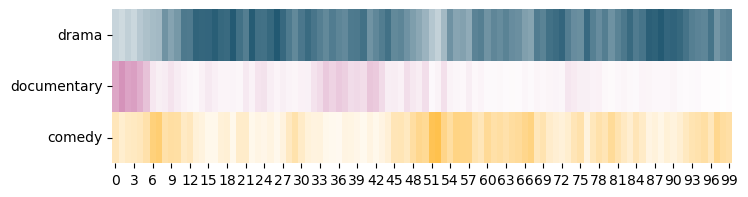

In [46]:
fig = plt.figure(figsize=(8,2))
ax = fig.add_subplot()

sns.heatmap(heatmap_df.T, cmap=colors_all, cbar=None, ax=ax)

plt.show()
plt.close()

### 5.3 Hidden State Distances

Component (D) gives us a glimpse of which steps in the sequence have the most impact on the model's predictions. At each step, it calculates the distance between the model's hidden state at that step and the hidden state at the previous step. The idea is that input words that move the hidden state by a greater distance are more impactful. It displays the information in a bar chart, with normalized distance represented by bar height and predictions (with confidence) represented by bar color.

In [47]:
def hidden_distances(hiddens):
    hiddens_lag = np.concatenate([np.zeros((1, hidden_size)), hiddens[:-1]])
    distances = np.sqrt(np.sum(np.square(hiddens - hiddens_lag), axis=1))
    return distances
    
def get_max_hidden_distance(all_hidden_states): # all_hidden_states is an iterable of tensors
    return max(hidden_distances(hiddens).max() for hiddens in all_hidden_states)  

def predictions_to_colors(predictions, confidences, max_alpha=0.75):
    return [tuple(color_float_map[pred] + [confidences[i]*max_alpha]) for i, pred in enumerate(predictions)]

In [48]:
with open('data/imdb_hiddens_{}_{}_{}.pkl'.format(len(GENRES), MIN_FREQ, MAX_LENGTH), 'rb') as f:
    all_hidden_states = pickle.load(f)

In [49]:
max_hidden_distance = get_max_hidden_distance(all_hidden_states)

In [50]:
distances = hidden_distances(hiddens)
distances_norm = distances/max_hidden_distance

In [51]:
movie_colors = predictions_to_colors(predictions, confidences, max_alpha=1)

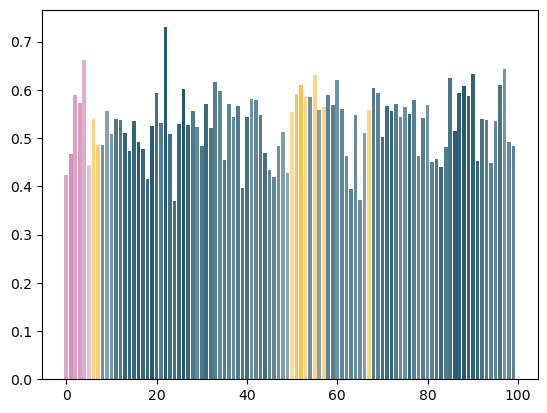

In [52]:
fig = plt.figure()
ax = fig.add_subplot()

ax.bar(x=[i for i in range(len(outputs))], height=distances_norm, color=movie_colors)

plt.show()
plt.close()

### 5.4 Hidden State Projection

Component (E) serves a dual purpose, giving us general information about the distribution of hidden states and predictions while showing how a given example evolves within that distribution. To create this visualization, we project the hidden states into 2 dimensions and color the points as in component (D) using the model's outputs. The original authors use t-SNE as their projection method, but we'll use PCA since it's less computationally expensive.

In [53]:
with open('data/imdb_outputs_{}_{}_{}.pkl'.format(len(GENRES), MIN_FREQ, MAX_LENGTH), 'rb') as f:
    all_outputs = pickle.load(f)

with open('data/imdb_predictions_{}_{}_{}.pkl'.format(len(GENRES), MIN_FREQ, MAX_LENGTH), 'rb') as f:
    all_predictions = pickle.load(f)

In [54]:
outputs_tensor = np.concatenate(all_outputs)
predictions_tensor = np.concatenate(all_predictions)

save_model_states.py fits a PCA model to the training data and pickles everything.

In [55]:
with open('saved_models/pca_{}_{}_{}.pkl'.format(len(GENRES), MIN_FREQ, MAX_LENGTH), 'rb') as f:   
    import warnings
    with warnings.catch_warnings(action="ignore"):
        ipca = pickle.load(f)
with open('data/imdb_hiddens_{}_{}_{}_pca.pkl'.format(len(GENRES), MIN_FREQ, MAX_LENGTH), 'rb') as f:
    hidden_pca = pickle.load(f)

In [56]:
scatter_colors = []
max_alpha = 0.4
for i, output in enumerate(outputs_tensor):
    pred = predictions_tensor[i]
    confidence = output[pred].item()
    scatter_colors.append(tuple(color_float_map[pred.item()] + [confidence*max_alpha]))

In [57]:
hidden_2D_df = pd.DataFrame(hidden_pca[:, 0:2], columns=['x', 'y'])
hidden_2D_df['scatter_color'] = scatter_colors

To improve graphing performance, we display a relatively small random sample of the projected points.

In [58]:
hidden_2D_sample = hidden_2D_df.sample(frac=0.001)

In [59]:
hiddens_transformed = ipca.transform(hiddens)

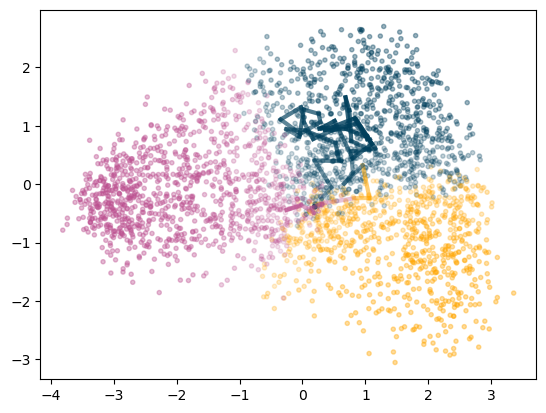

In [60]:
fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(hidden_2D_sample['x'], hidden_2D_sample['y'], marker='.', c=hidden_2D_sample['scatter_color'])
for i, coords in enumerate(hiddens_transformed[:50]):
    ax.plot(hiddens_transformed[i:i+2,0], hiddens_transformed[i:i+2,1], c=movie_colors[i], linewidth=3)

plt.show()
plt.close()

The 2D projection does a pretty good job separating the class predictions. The first principal component (X-axis) separates documentaries from dramas and comedies, and the second principal component separates dramas from comedies.

The colored lines show the progression of the example movie description through the hidden state space.